In [6]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
#from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.loop import loop
from meshmaker.loop import loop as Loop
from meshmaker.delaunay import triangulation
from meshmaker.planargraph import planargraph
#from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, loop_split, isnear, near, loopO
from meshmaker.geometry import batch, slide, isnear, near, sintsxyp
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader, LazyMaterials
from meshmaker.plt import *
from collections import defaultdict
from functools import partial, reduce
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U(0.1))], background=vec3.U(0.8))

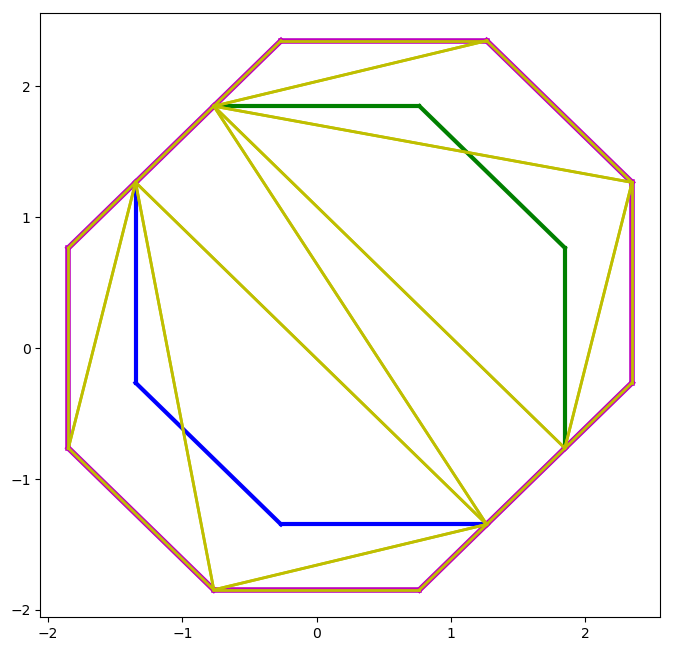

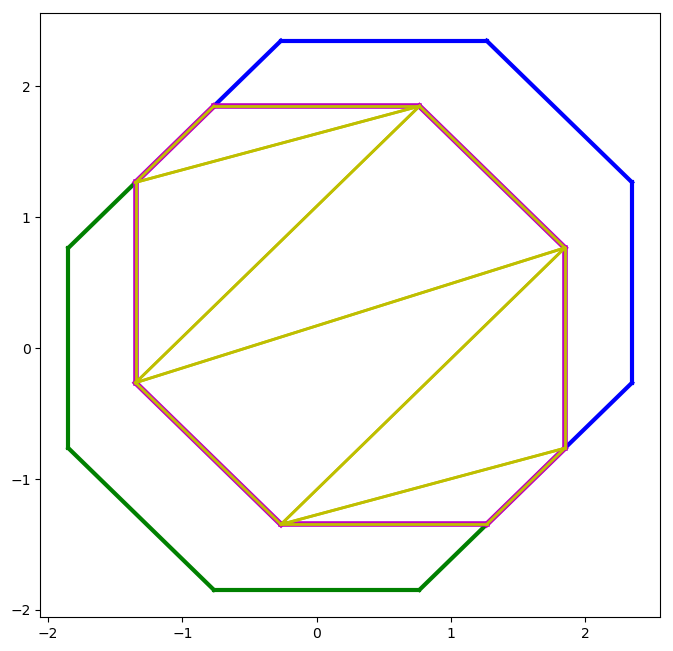

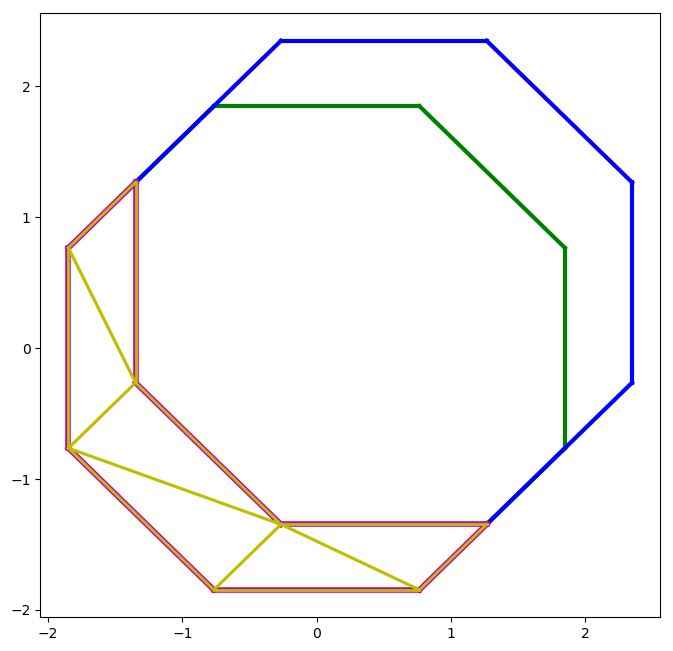

In [7]:
a = loop(vec3.O().ring(2, 8))
b = loop(vec3.U(0.5).xy().ring(2, 8))

def test_booleans():
    u = a.union(b)
    i = a.intersect(b)
    d = a.difference(b)
    
    f, ax = plot()
    plot_loop(ax, a.ps, col='g')
    plot_loop(ax, b.ps, col='b')
    for p in u:
        plot_loop(ax, p.ps, col='m', lw=4)
        for t in p.triangulation().simplices():
            plot_loop(ax, list(t), col='y', lw=2)
    
    f, ax = plot()
    plot_loop(ax, a.ps, col='g')
    plot_loop(ax, b.ps, col='b')
    for p in i:
        plot_loop(ax, p.ps, col='m', lw=4)
        for t in p.triangulation().simplices():
            plot_loop(ax, list(t), col='y', lw=2)
    
    f, ax = plot()
    plot_loop(ax, a.ps, col='g')
    plot_loop(ax, b.ps, col='b')
    for p in d:
        plot_loop(ax, p.ps, col='m', lw=4)
        for t in p.triangulation().simplices():
            plot_loop(ax, list(t), col='y', lw=2)
    
test_booleans()

8 16
11.313708498984761
11.191581171480154
[11.191900239999999, 11.19190024]


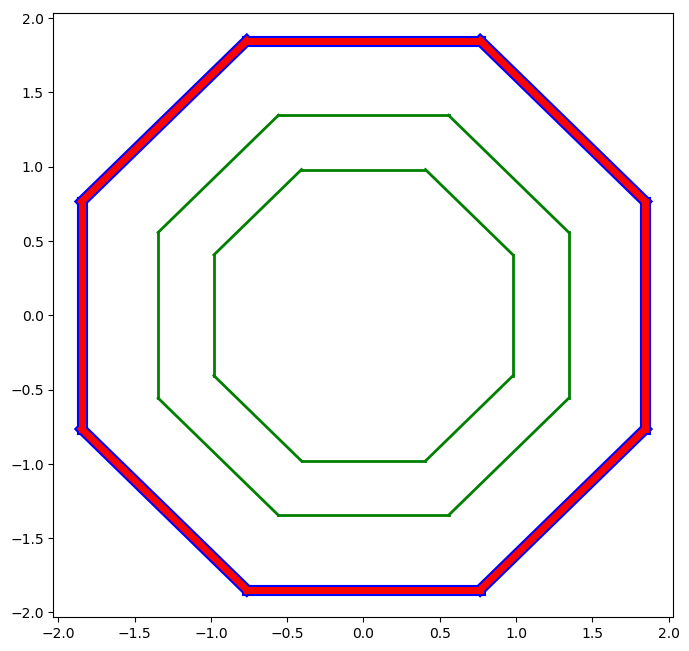

In [8]:
def tests():
    l1 = loop(vec3.O().ring(2, 8))
    assert l1.N.isnear(vec3.Z())
    assert isnear(l1.area, 11, 1)
    
    l2 = l1.edgesplit(1)
    print(len(l1), len(l2))
    assert (len(l2) == len(l1) * 2)
    
    l3 = l1.cp().smooth(iterations=2)
    l4 = l1.cp().smooth(iterations=4)
    
    l5 = l1.cp().rot(quat.toxy(vec3.X()))
    l6 = l5.offset(0.01)
    print(l5.area)
    print(l6.area)
    
    l7s = l5.intersect(l6)
    print([l.area for l in l7s])
    
    f, ax = plot()
    plot_loop(ax, l1.ps, col='b', lw=8)
    plot_loop(ax, l2.ps, col='r', lw=5)
    plot_loop(ax, l3.ps, col='g', lw=2)
    plot_loop(ax, l4.ps, col='g', lw=2)
    
tests()

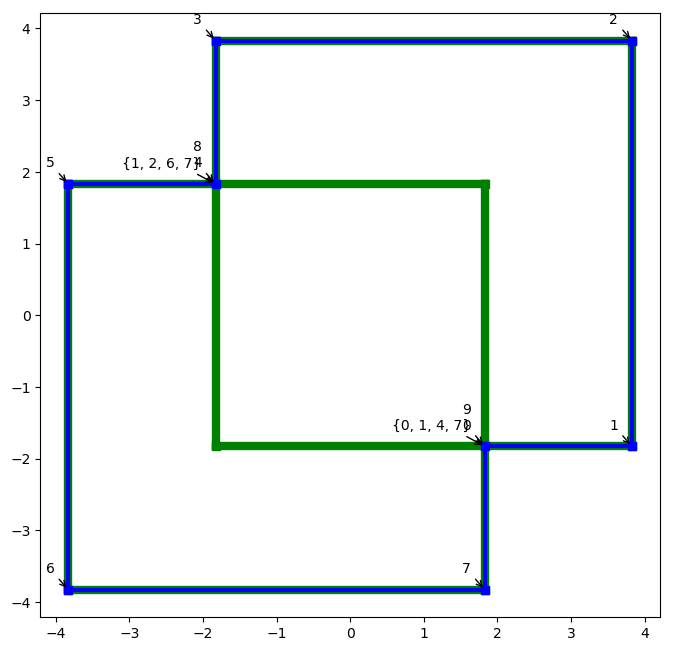

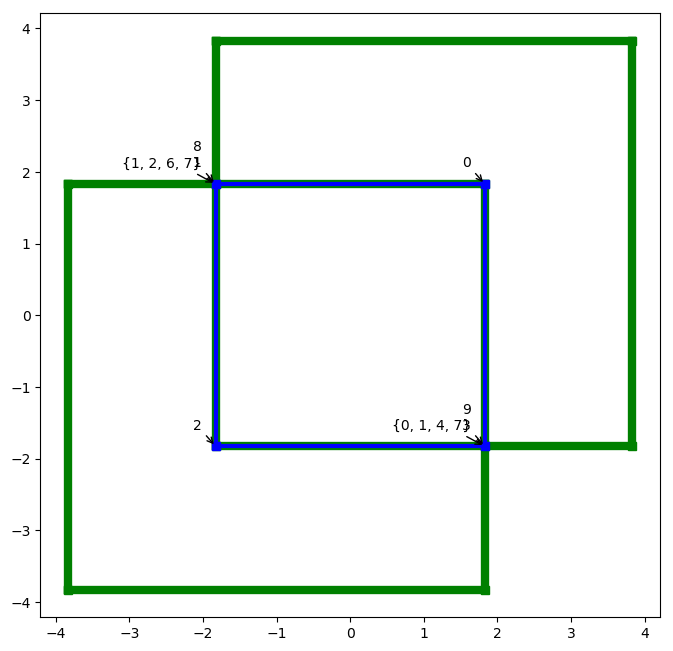

In [9]:
def test():
    l1, l2 = vec3(-1, -1, 0).ring(4, 4), vec3(1, 1, 0).ring(4, 4)

    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    
    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    #union = loop_union(l1, l2)
    union = [x.ps for x in Loop(l1).union(Loop(l2))]
    for u in union:
        plot_loop(ax, u, lw=3, col='b', mk='s')

    #f, ax = plot()
    #plot_pg(ax, pg, lw=6, col='g', mk='s')
    
    #diff = loop_difference(l1, l2)
    #for d in diff:
    #    plot_loop(ax, d, lw=3, col='b', mk='s')

    f, ax = plot()
    plot_pg(ax, pg, lw=6, col='g', mk='s')
    #intersection = loop_intersection(l1, l2)
    intersection = [x.ps for x in Loop(l1).intersect(Loop(l2))]
    for i in intersection:
        plot_loop(ax, i, lw=3, col='b', mk='s')
    
test()